In [1]:
!pip install captum
!pip install ray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.3 MB/s eta 0:00:00


In [2]:
%matplotlib inline

In [3]:
import numpy as np
from sklearn import metrics
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import transforms
from torchvision import models
from torchvision.models import ResNet34_Weights
from PIL import Image
import matplotlib.pyplot as plt

# Ray Tune
import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

import warnings
warnings.filterwarnings("ignore")

from matplotlib.colors import LinearSegmentedColormap
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

Creat two dataset classes for training dataset and testing dataset. Both of the classes read the csv in `_init_` but leave the reading of images to `_getitem_`. This is memory efficient because all the images are not stored in the memory at once but read as required.

Sample of the training dataset is a dict `{'image': image, 'label': label}` and sample of the test dataset is a dict `{'image': image}`. Our dataset will take an optional argument `transform` so that any required processing can be applied on the sample. We will see the usefulness of `transform` in the next section.

In [4]:
# create the train dataset
class NucleusTypeDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.nuclei_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.nuclei_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.nuclei_frame.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.nuclei_frame.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label
    
# Create the test dataset
class NucleusTypeTestDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image

Do transform work and use `ToTensor` to convert the numpy images to torch images so we can use them with our network.

In [5]:
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

Create the dataset and split into training and validation datasets.

In [6]:
def load_data(data_dir ='/kaggle/input/deep-learning-for-msc-2022-23/train'):
    dataset = NucleusTypeDataset(csv_file='/kaggle/input/deep-learning-for-msc-2022-23/train.csv',
                            root_dir= data_dir,
                            transform=transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    return train_dataset, val_dataset

# Model 1

`ModelCNN` is a PyTorch implementation of a convolutional neural network (CNN) model for image classification. The model has two convolutional layers (`self.conv1` and `self.conv2`) with ReLU activation function, followed by max pooling (`self.pool`) and two fully connected layers (`self.fc1` and `self.fc2`) also with ReLU activation. The last fully connected layer (`self.fc3`) has 4 output nodes, which suggests that the model is designed for classifying images into 4 classes.

The `__init__` method initializes the model's layers, and the `forward` method defines how the input data is processed through the layers.

In [7]:
class ModelCNN(nn.Module):
    def __init__(self,l1=128,l2=64):
        super(ModelCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(12, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 25 * 25, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 4)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 32 * 25 * 25)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Define a function `train_model_1` that trains a CNN model using PyTorch and reports the training progress using Ray Tune.

The function first loads the training and validation datasets using the `load_data()` function, which is not shown in the code snippet. Then, it defines the model architecture by creating an instance of the `ModelCNN` class with the specified configuration parameters. The model is then moved to the GPU if available.

The loss function is set to cross-entropy loss, and the optimizer is set to Adam with the learning rate specified in the configuration parameters. If a checkpoint directory is provided, the function loads the model and optimizer states from the checkpoint file.

The function then trains the model for 10 epochs using a nested loop over the batches in the training data. For each batch, it calculates the loss, backpropagates the gradients, and updates the model parameters using the optimizer.

After training, the function evaluates the model on the validation set. It calculates the validation loss and accuracy by iterating over the batches in the validation data, calculating the model outputs and loss, and computing the number of correct predictions.

The function uses Ray Tune to report the training progress by calling the `tune.report()` function with the training loss, validation accuracy, and validation loss. It also saves the model and optimizer states in a checkpoint file using the `tune.checkpoint_dir()` function.

## Train and Validate

In [8]:
def train_model_1(config,checkpoint_dir=None):
    
    # Define data loaders
    train_dataset, val_dataset = load_data()
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=True)
    
    # Define model architecture
    model = ModelCNN(config['l1'], config['l2'])
    
    # make GPU do the training
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    
    # set the loss function to optimise
    criterion = nn.CrossEntropyLoss()
    # set the optimeiser as Adm
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
        
    # Train the model
    train_loss = 0.0
    for epoch in range(20):
        for i, data in enumerate(train_loader, 0):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

    train_loss = round(train_loss/(len(train_loader)*5),3)


    # Validate the model
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss = round(val_loss/len(val_loader),3)
    val_accuracy = round(val_correct / val_total,3)
    
    with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)
            
    tune.report(train_loss=train_loss,val_accuracy=val_accuracy,val_loss=val_loss)
    

Define a configuration dictionary containing the hyperparameters: `l1` `l2` `lr` and `batch_size`, and sample values for these hyperparameters using the `tune.sample_from()` and `tune.loguniform()` functions.

 Use a command-line reporter `CLIReporter` to print the progress of the experiment to the console, and an asynchronous hyperband scheduler `ASHAScheduler` to manage the hyperparameter search process.

 Report the train_loss, val_accuracy, and val_loss metrics to Tune.

 Finally, run the hyperparameter search using `tune.run()` function and saving the results of the experiment in the analysis variable.

In [9]:
if __name__ == "__main__":

    config = {
        "l1": tune.sample_from(lambda _: 2**np.random.randint(5, 9)),
        'l2': tune.sample_from(lambda _: 2**np.random.randint(5, 9)),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([32, 64, 128, 256])
    }

    reporter = CLIReporter(
                metric_columns = ["train_loss","val_accuracy","val_loss"],
                max_progress_rows=10      
        )
    
    scheduler = ASHAScheduler(max_t=100, grace_period=1)

    analysis = tune.run(
        train_model_1,
        config=config,
        metric="val_accuracy",
        mode="max",
        resources_per_trial={'cpu': 2, 'gpu': 2},
        num_samples=3,
        scheduler=scheduler,
        progress_reporter=reporter
    )
print('Finished Training')

2023-03-23 03:12:54,341	INFO worker.py:1535 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
/opt/conda/lib/python3.7/site-packages/ray/tune/trainable/function_trainable.py:612: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/master/tune/api_docs/trainable.html

  DeprecationWarning,
E0323 03:12:57.581649637      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-23 03:12:58 (running for 00:00:00.48)
Memory usage on this node: 1.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_1_2023-03-23_03-12-57
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+---------------------------+----------+----------------+--------------+------+------+------------+
| Trial name                | status   | loc            |   batch_size |   l1 |   l2 |         lr |
|---------------------------+----------+----------------+--------------+------+------+------------|
| train_model_1_9c4ac_00000 | RUNNING  | 172.19.2.2:306 |          256 |  128 |   32 | 0.021055   |
| train_model_1_9c4ac_00001 | PENDING  |                |           64 |  256 |   64 | 0.00714768 |
| train_model_1_9c4ac_00002 | PENDING  |

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train_loss,training_iteration,trial_id,val_accuracy,val_loss,warmup_time
train_model_1_9c4ac_00000,2023-03-23_03-18-15,True,,7054f8aae3e24c82921b1ff0721fe2ff,558028f1230e,1,172.19.2.2,306,True,312.544,312.544,312.544,1679541495,0,,1.882,1,9c4ac_00000,0.827,0.754,0.0121772
train_model_1_9c4ac_00001,2023-03-23_03-23-17,True,,ba07b4f6168a445ebb8912ada2574e89,558028f1230e,1,172.19.2.2,1566,True,296.41,296.41,296.41,1679541797,0,,0.902,1,9c4ac_00001,0.86,0.645,0.00486207
train_model_1_9c4ac_00002,2023-03-23_03-28-28,True,,1649fc4579184e7ca1a70fb5050dbb3e,558028f1230e,1,172.19.2.2,5691,True,304.823,304.823,304.823,1679542108,0,,1.315,1,9c4ac_00002,0.797,0.919,0.00602651


== Status ==
Current time: 2023-03-23 03:18:21 (running for 00:05:23.49)
Memory usage on this node: 1.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.827
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: 9c4ac_00000 with val_accuracy=0.827 and parameters={'l1': 128, 'l2': 32, 'lr': 0.02105501650144914, 'batch_size': 256}
Result logdir: /root/ray_results/train_model_1_2023-03-23_03-12-57
Number of trials: 3/3 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------------+------------+-----------------+--------------+------+------+------------+--------------+----------------+------------+
| Trial name                | status     | loc             |   batch_size |   l1 |   l2 |         lr |   train_loss |   val_accuracy |   val_loss |
|---------------------------+------------+-----------------+--------------+------+------+-

2023-03-23 03:28:28,464	INFO tune.py:763 -- Total run time: 930.94 seconds (930.43 seconds for the tuning loop).


== Status ==
Current time: 2023-03-23 03:28:28 (running for 00:15:30.45)
Memory usage on this node: 4.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.8434999999999999
Resources requested: 0/2 CPUs, 0/2 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: 9c4ac_00001 with val_accuracy=0.86 and parameters={'l1': 256, 'l2': 64, 'lr': 0.007147678805583245, 'batch_size': 64}
Result logdir: /root/ray_results/train_model_1_2023-03-23_03-12-57
Number of trials: 3/3 (3 TERMINATED)
+---------------------------+------------+-----------------+--------------+------+------+------------+--------------+----------------+------------+
| Trial name                | status     | loc             |   batch_size |   l1 |   l2 |         lr |   train_loss |   val_accuracy |   val_loss |
|---------------------------+------------+-----------------+--------------+------+------+------------+--

In [10]:
best_trial = analysis.get_best_trial("val_loss", "min", "last")
configuration = best_trial.config
print("Best trial config: {}".format(configuration))
print("Best trial producing loss: {}".format(best_trial.last_result["train_loss"]))
print("Best trial final validation loss: {}".format(best_trial.last_result["val_loss"]))
print("Best trial final validation accuracy: {}".format(best_trial.last_result["val_accuracy"]))

Best trial config: {'l1': 256, 'l2': 64, 'lr': 0.007147678805583245, 'batch_size': 64}
Best trial producing loss: 0.902
Best trial final validation loss: 0.645
Best trial final validation accuracy: 0.86


Get tge best trained model and load the parameters into the optimizer.

In [11]:
# Use the best trained model
best_trained_model = ModelCNN(configuration["l1"], configuration['l2'])

# Load the configuration into the optimizer
optimizer = optim.Adam(best_trained_model.parameters(), lr=configuration["lr"])

criterion = nn.CrossEntropyLoss()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
        best_trained_model = nn.DataParallel(best_trained_model)
best_trained_model.to(device)

print(best_trained_model)


DataParallel(
  (module): ModelCNN(
    (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=20000, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=4, bias=True)
  )
)


This code appears to be training the `best_trained_model` using PyTorch. It is using two data loaders (`train_loader` and `val_loader`) to load the training and validation datasets, respectively. The `train_loader` is used to train the model with backpropagation, while the `val_loader` is used to evaluate the model's performance during training.

The `train_lossSet`, `val_lossSet`, and `val_accuSet` are lists used to store the training loss, validation loss, and validation accuracy, respectively, for each epoch of training.

The code then enters a loop that trains the model for 20 epochs. During each epoch, it loops over the batches in the `train_loader` and performs forward and backward passes to update the model's weights. After each epoch of training, the code evaluates the model's performance on the validation dataset by looping over the batches in the `val_loader` and computing the validation loss and accuracy.

Finally, the code prints the training loss, validation loss, and validation accuracy for each epoch.

In [12]:
# load dataset
train_dataset, val_dataset = load_data()
train_loader = DataLoader(train_dataset, batch_size=configuration["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=configuration["batch_size"], shuffle=True)

# The train_lossSet, val_lossSet, and val_accuSet are lists used to store the training loss, validation loss, and validation accuracy, respectively, for each epoch of training.
train_lossSet = []
val_lossSet = []
val_accuSet = []
for epoch in range(20):
    train_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = best_trained_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    train_loss = train_loss / len(train_loader)
    train_lossSet.append(train_loss)
    
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    for i, data in enumerate(val_loader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = best_trained_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()
    val_loss = train_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_lossSet.append(val_loss)
    val_accuSet.append(val_accuracy)

    print("train_loss:",train_loss, " val_loss:",val_loss," val_acc:",val_accuracy)

train_loss: 1.12227520942688  val_loss: 0.04676146705945333  val_acc: 0.7129629629629629
train_loss: 0.6746352854527925  val_loss: 0.028109803560533022  val_acc: 0.8154761904761905
train_loss: 0.44429582059383393  val_loss: 0.018512325858076415  val_acc: 0.8571428571428571
train_loss: 0.34616611984215284  val_loss: 0.014423588326756368  val_acc: 0.8902116402116402
train_loss: 0.2873125650380787  val_loss: 0.011971356876586613  val_acc: 0.91005291005291
train_loss: 0.2307859793305397  val_loss: 0.009616082472105821  val_acc: 0.9206349206349206
train_loss: 0.19404029889326346  val_loss: 0.008085012453885978  val_acc: 0.9451058201058201
train_loss: 0.1772421417267699  val_loss: 0.007385089238615412  val_acc: 0.9490740740740741
train_loss: 0.13943787544573608  val_loss: 0.0058099114769056695  val_acc: 0.9623015873015873
train_loss: 0.10691217252690541  val_loss: 0.004454673855287725  val_acc: 0.9768518518518519
train_loss: 0.08289556155275357  val_loss: 0.0034539817313647323  val_acc: 0.98

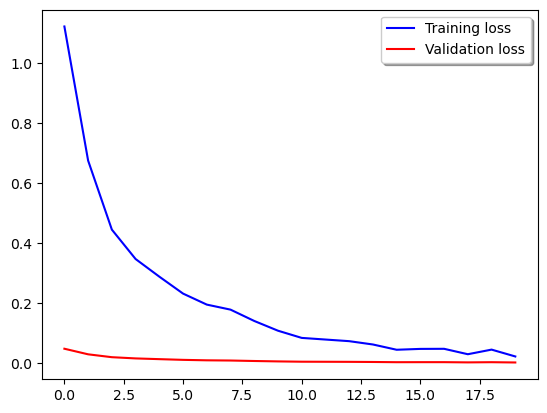

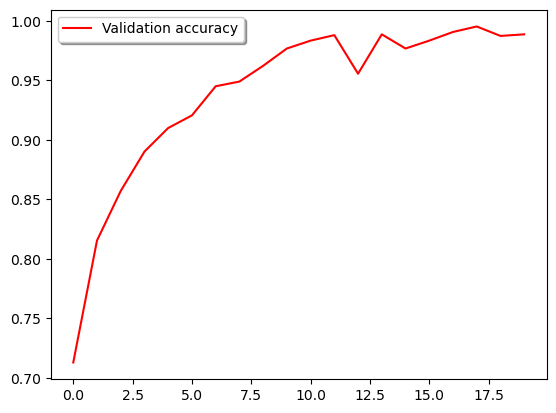

In [13]:
plt.figure()
plt.plot(train_lossSet, color='b', label="Training loss")
plt.plot(val_lossSet, color='r', label="Validation loss")
legend = plt.legend(shadow=True)

plt.figure()
plt.plot(val_accuSet, color='r',label="Validation accuracy")
legend = plt.legend(shadow=True)

Load the testing dataset and do predict. Then create a file `submission.csv` to store the result.

In [14]:
test_dataset = NucleusTypeTestDataset(csv_file='/kaggle/input/deep-learning-for-msc-2022-23/example.csv',
                                 root_dir= '/kaggle/input/deep-learning-for-msc-2022-23/test',
                                 transform=transform)
test_loader = DataLoader(test_dataset, batch_size=configuration["batch_size"], shuffle=False)


In [15]:
# Make predictions on the test dataset
best_trained_model.eval()
predictions = []

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs = data
        inputs = inputs.to(device)
        outputs = best_trained_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        for p in predicted:
            predictions.append(p.item())


In [16]:
submission_df = pd.DataFrame({'Filename': test_dataset.data['Filename'], 'Label': predictions})
submission_df.to_csv('submission_1.csv', index=False)

Evaluate the performance of the trained model on the training dataset and generating a confusion matrix to visualize the model's predictions.

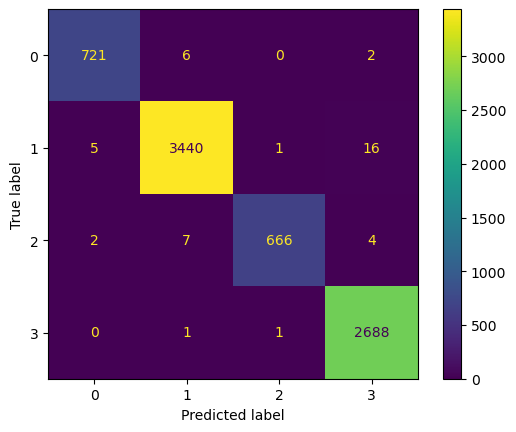

In [17]:
# Get actual and predicted values
dataset =  NucleusTypeDataset(csv_file='/kaggle/input/deep-learning-for-msc-2022-23/train.csv',
                         root_dir= '/kaggle/input/deep-learning-for-msc-2022-23/train',
                         transform=transform)

loader = DataLoader(dataset, batch_size=best_trial.config["batch_size"], shuffle=True)

y_actual=[]
y_pred=[]
with torch.no_grad():
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_trained_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        size = labels.size(0)
        for i in range(0,size):
            y_actual.append(int(labels[i]))
            y_pred.append(int(predicted[i]))

# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y_actual, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2, 3])

cm_display.plot()
plt.show()

In [18]:
# Captum Model Part
ig = IntegratedGradients(best_trained_model)
image_path = '/kaggle/input/deep-learning-for-msc-2022-23/test/14840.png'
img = Image.open(image_path)

In [19]:
transform = transforms.Compose([
 transforms.Resize(100),
 transforms.CenterCrop(100),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
)

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

In [20]:
output = best_trained_model(input.to(device))
output = F.softmax(output, dim=1)
pred_label_idx = torch.topk(output, 1)
_, pred_label_idx = torch.topk(output, 1)


## Gradient-based attribution

Let's compute attributions using Integrated Gradients and visualize them on the image. Integrated gradients computes the integral of the gradients of the output of the model for the predicted class `pred_label_idx` with respect to the input image pixels along the path from the black image to our input image.


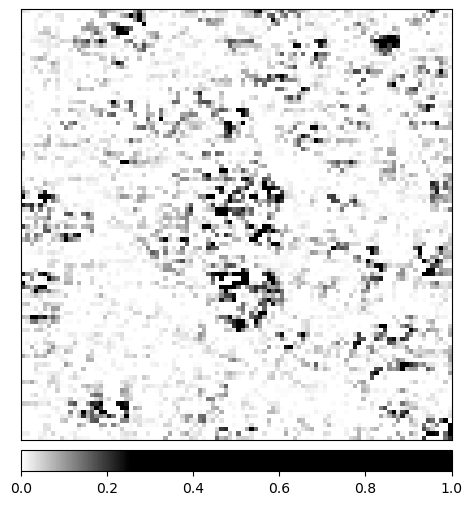

In [21]:
integrated_gradients = IntegratedGradients(best_trained_model)
attributions_ig = integrated_gradients.attribute(input.to(device), target=pred_label_idx, n_steps=200)

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

Let us compute attributions using Integrated Gradients and smoothens them across multiple images generated by a noise tunnel. The latter adds gaussian noise with a std equals to one, 10 times (`nt_samples=10`) to the input. Ultimately, noise tunnel smoothens the attributions across `nt_samples` noisy samples using `smoothgrad_sq` technique. `smoothgrad_sq` represents the mean of the squared attributions across `nt_samples` samples.

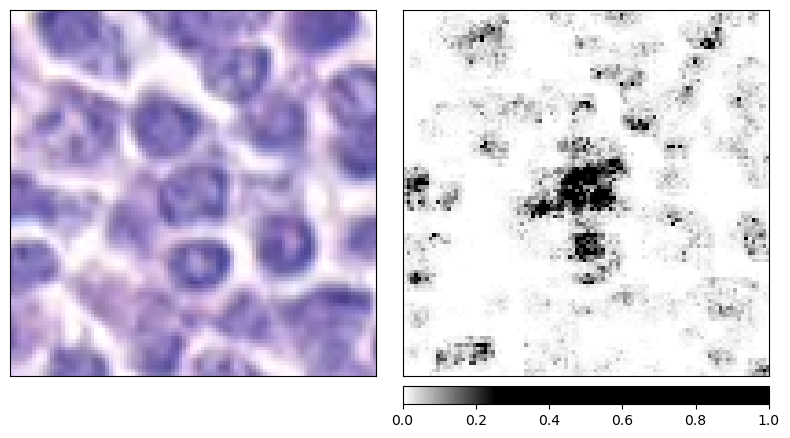

In [22]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input.to(device), nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


Finally, let us use `GradientShap`, a linear explanation model which uses a distribution of reference samples (in this case two images) to explain predictions of the model. It computes the expectation of gradients for an input which was chosen randomly between the input and a baseline. The baseline is also chosen randomly from given baseline distribution.

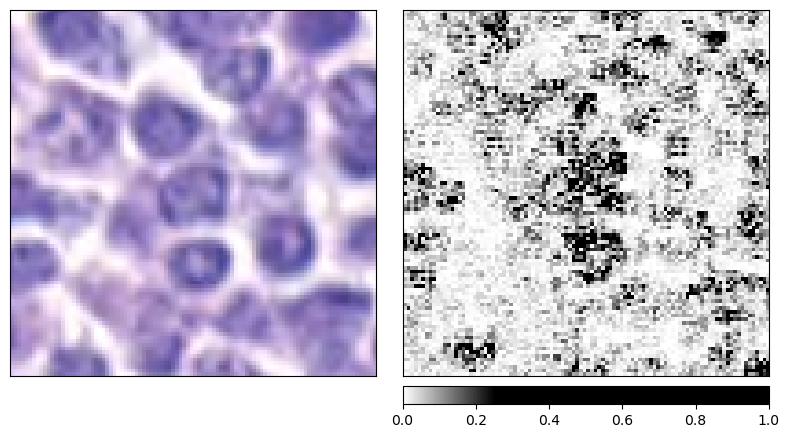

In [23]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(best_trained_model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input.to(device) * 0, input .to(device)* 1])

attributions_gs = gradient_shap.attribute(input.to(device),
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


## Occlusion-based attribution

Now let us try a different approach to attribution. We can estimate which areas of the image are critical for the classifier's decision by occluding them and quantifying how the decision changes.

We run a sliding window of size 15x15 (defined via `sliding_window_shapes`) with a stride of 8 along both image dimensions (a defined via `strides`). At each location, we occlude the image with a baseline value of 0 which correspondes to a gray patch (defined via `baselines`).

Note: this computation might take more than one minute to complete, as the model is evaluated at every position of the sliding window.

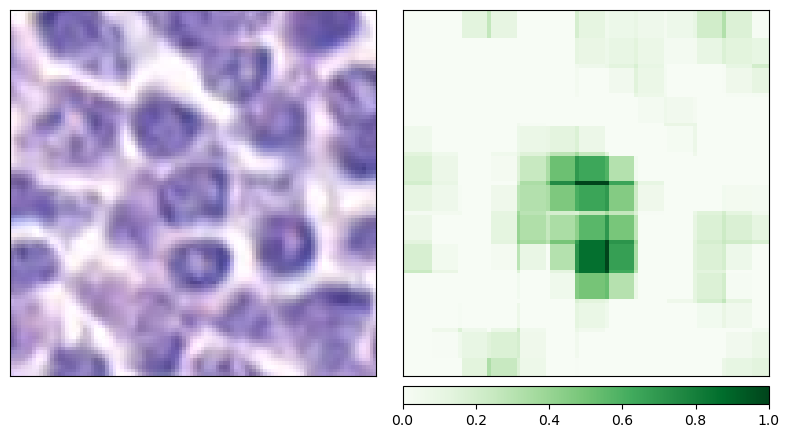

In [24]:
occlusion = Occlusion(best_trained_model)

attributions_occ = occlusion.attribute(input.to(device),
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

# visualize the attribution, focusing on the areas with positive attribution (those that are critical for the classifier's decision)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )


Occlude the image using a larger sliding window.

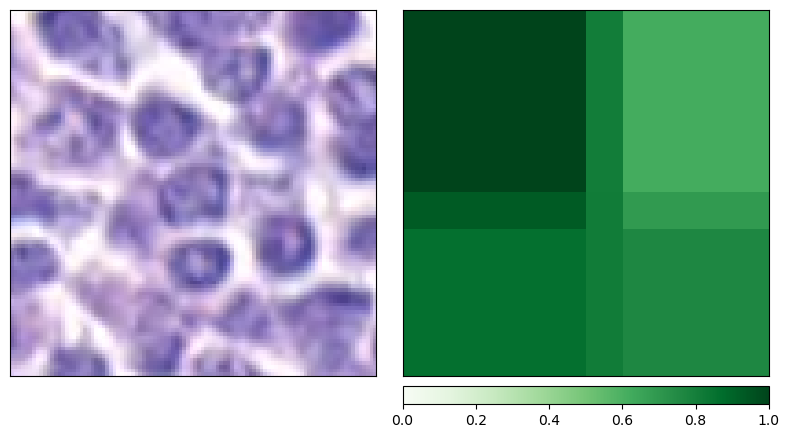

In [25]:
occlusion = Occlusion(best_trained_model)

attributions_occ = occlusion.attribute(input.to(device),
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

# Model 2

The code in this section is almost identical to model 1, except that an existing torchvision model which is pre-trained on ImageNet is used.

In [26]:
pre_trained_model = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

## Train and Validate

In [27]:
def train_model_2(config,checkpoint_dir=None):
    
    # Define data loaders
    train_dataset, val_dataset = load_data()
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=True)
    
    # Define model architecture
    pre_trained_model = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
    
    # make GPU do the training
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            pre_trained_model = nn.DataParallel(pre_trained_model)
    pre_trained_model.to(device)
    
    # set the loss function to optimise
    criterion = nn.CrossEntropyLoss()
    # set the optimeiser as Adm
    optimizer = optim.Adam(pre_trained_model.parameters(), lr=config["lr"])
    
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        pre_trained_model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
        
    # Train the model
    train_loss = 0.0
    for epoch in range(20):
        for i, data in enumerate(train_loader, 0):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = pre_trained_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

    train_loss = round(train_loss/(len(train_loader)*5),3)


    # Validate the model
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = pre_trained_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss = round(val_loss/len(val_loader),3)
    val_accuracy = round(val_correct / val_total,3)
    
    with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((pre_trained_model.state_dict(), optimizer.state_dict()), path)
            
    tune.report(train_loss=train_loss,val_accuracy=val_accuracy,val_loss=val_loss)

In [28]:
if __name__ == "__main__":

    config = {
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([32, 64, 128, 256])
    }

    reporter = CLIReporter(
                metric_columns = ["train_loss","val_accuracy","val_loss"],
                max_progress_rows=10      
        )
    
    scheduler = ASHAScheduler(max_t=100, grace_period=1)

    analysis = tune.run(
        train_model_2,
        config=config,
        metric="val_accuracy",
        mode="max",
        resources_per_trial={'cpu': 2, 'gpu': 2},
        num_samples=3,
        scheduler=scheduler,
        progress_reporter=reporter
    )
print('Finished Training')

== Status ==
Current time: 2023-03-23 03:35:43 (running for 00:00:00.18)
Memory usage on this node: 4.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2_2023-03-23_03-35-43
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+---------------------------+----------+------------------+--------------+-------------+
| Trial name                | status   | loc              |   batch_size |          lr |
|---------------------------+----------+------------------+--------------+-------------|
| train_model_2_ca882_00000 | RUNNING  | 172.19.2.2:19154 |          128 | 0.000131088 |
| train_model_2_ca882_00001 | PENDING  |                  |          256 | 0.00119766  |
| train_model_2_ca882_00002 | PENDING  |                  |          256 | 0.000899393 |
+-----

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train_loss,training_iteration,trial_id,val_accuracy,val_loss,warmup_time
train_model_2_ca882_00000,2023-03-23_03-41-50,True,,110359fea0e34bfbb93daef63272af5b,558028f1230e,1,172.19.2.2,19154,True,362.085,362.085,362.085,1679542910,0,,0.395,1,ca882_00000,0.968,0.106,0.00508547
train_model_2_ca882_00001,2023-03-23_03-47-37,True,,ac1565aa3f6647bbb123d1454cf7a1f3,558028f1230e,1,172.19.2.2,21429,True,341.436,341.436,341.436,1679543257,0,,0.314,1,ca882_00001,0.978,0.089,0.00563264
train_model_2_ca882_00002,2023-03-23_03-53-24,True,,06e500643ad14af993368863430688e6,558028f1230e,1,172.19.2.2,22715,True,340.317,340.317,340.317,1679543604,0,,0.303,1,ca882_00002,0.972,0.108,0.00596237


== Status ==
Current time: 2023-03-23 03:41:56 (running for 00:06:12.82)
Memory usage on this node: 5.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.968
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: ca882_00000 with val_accuracy=0.968 and parameters={'lr': 0.00013108813258313497, 'batch_size': 128}
Result logdir: /root/ray_results/train_model_2_2023-03-23_03-35-43
Number of trials: 3/3 (1 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------------+------------+------------------+--------------+-------------+--------------+----------------+------------+
| Trial name                | status     | loc              |   batch_size |          lr |   train_loss |   val_accuracy |   val_loss |
|---------------------------+------------+------------------+--------------+-------------+--------------+----------------+----------

2023-03-23 03:53:24,626	INFO tune.py:763 -- Total run time: 1060.94 seconds (1060.79 seconds for the tuning loop).


== Status ==
Current time: 2023-03-23 03:53:24 (running for 00:17:40.81)
Memory usage on this node: 8.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.975
Resources requested: 0/2 CPUs, 0/2 GPUs, 0.0/7.4 GiB heap, 0.0/3.7 GiB objects (0.0/1.0 accelerator_type:T4)
Current best trial: ca882_00001 with val_accuracy=0.978 and parameters={'lr': 0.0011976595777317828, 'batch_size': 256}
Result logdir: /root/ray_results/train_model_2_2023-03-23_03-35-43
Number of trials: 3/3 (3 TERMINATED)
+---------------------------+------------+------------------+--------------+-------------+--------------+----------------+------------+
| Trial name                | status     | loc              |   batch_size |          lr |   train_loss |   val_accuracy |   val_loss |
|---------------------------+------------+------------------+--------------+-------------+--------------+----------------+------------|
| train_model_2_ca882_0

In [29]:
best_trial = analysis.get_best_trial("val_loss", "min", "last")
configuration = best_trial.config
print("Best trial config: {}".format(configuration))
print("Best trial producing loss: {}".format(best_trial.last_result["train_loss"]))
print("Best trial final validation loss: {}".format(best_trial.last_result["val_loss"]))
print("Best trial final validation accuracy: {}".format(best_trial.last_result["val_accuracy"]))

Best trial config: {'lr': 0.0011976595777317828, 'batch_size': 256}
Best trial producing loss: 0.314
Best trial final validation loss: 0.089
Best trial final validation accuracy: 0.978


In [30]:
# Use the best trained model
pre_trained_model = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

# Load the optimizer state into the optimizer object
optimizer = optim.Adam(pre_trained_model.parameters(), lr=configuration["lr"])

criterion = nn.CrossEntropyLoss()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
        pre_trained_model = nn.DataParallel(pre_trained_model)
pre_trained_model.to(device)

print(pre_trained_model)


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [31]:
train_dataset, val_dataset = load_data()
train_loader = DataLoader(train_dataset, batch_size=configuration["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=configuration["batch_size"], shuffle=True)

train_lossSet = []
val_lossSet = []
val_accuSet = []

for epoch in range(20):
    train_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = pre_trained_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    train_loss = train_loss / len(train_loader)
    train_lossSet.append(train_loss)
    
    
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    for i, data in enumerate(val_loader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = pre_trained_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()
    val_loss = train_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_lossSet.append(val_loss)
    val_accuSet.append(val_accuracy)

    print("train_loss:",train_loss, " val_loss:",val_loss," val_acc:",val_accuracy)

train_loss: 1.0523822971930106  val_loss: 0.17539704953216842  val_acc: 0.9378306878306878
train_loss: 0.12150065399085481  val_loss: 0.0202501089984758  val_acc: 0.9702380952380952
train_loss: 0.05251285224221647  val_loss: 0.008752142040369412  val_acc: 0.9854497354497355
train_loss: 0.04371746947678427  val_loss: 0.0072862449127973775  val_acc: 0.9887566137566137
train_loss: 0.0189236499039301  val_loss: 0.003153941650655017  val_acc: 0.9947089947089947
train_loss: 0.03297523634197811  val_loss: 0.005495872723663018  val_acc: 0.9920634920634921
train_loss: 0.019825030942835536  val_loss: 0.0033041718238059226  val_acc: 0.9861111111111112
train_loss: 0.03335058743444582  val_loss: 0.005558431239074304  val_acc: 0.9887566137566137
train_loss: 0.026388718086915713  val_loss: 0.0043981196811526185  val_acc: 0.9920634920634921
train_loss: 0.023723284369528603  val_loss: 0.003953880728254767  val_acc: 0.9907407407407407
train_loss: 0.016054689636803232  val_loss: 0.002675781606133872  val

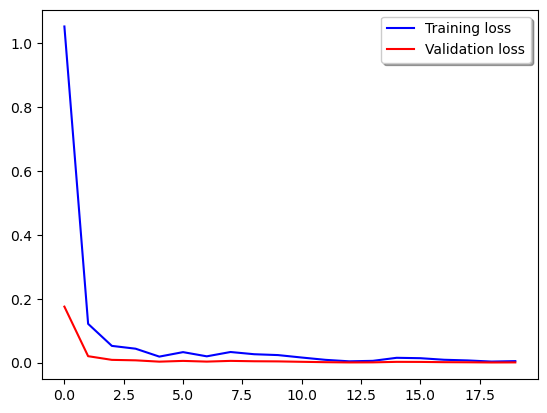

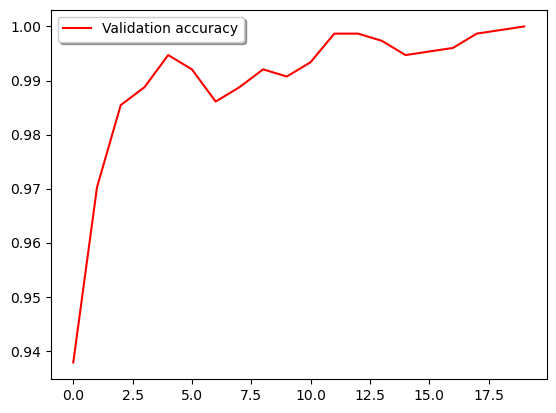

In [32]:
plt.figure()
plt.plot(train_lossSet, color='b', label="Training loss")
plt.plot(val_lossSet, color='r', label="Validation loss")
legend = plt.legend(shadow=True)

plt.figure()
plt.plot(val_accuSet, color='r',label="Validation accuracy")
legend = plt.legend(shadow=True)

In [33]:
test_dataset = NucleusTypeTestDataset(csv_file='/kaggle/input/deep-learning-for-msc-2022-23/example.csv',
                                 root_dir= '/kaggle/input/deep-learning-for-msc-2022-23/test',
                                 transform=transform)
test_loader = DataLoader(test_dataset, batch_size=configuration["batch_size"], shuffle=False)

In [34]:
# Make predictions on the test dataset
pre_trained_model.eval()
predictions = []

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs = data
        inputs = inputs.to(device)
        outputs = pre_trained_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        for p in predicted:
            predictions.append(p.item())

In [35]:
submission_df = pd.DataFrame({'Filename': test_dataset.data['Filename'], 'Label': predictions})
submission_df.to_csv('submission_2.csv', index=False)

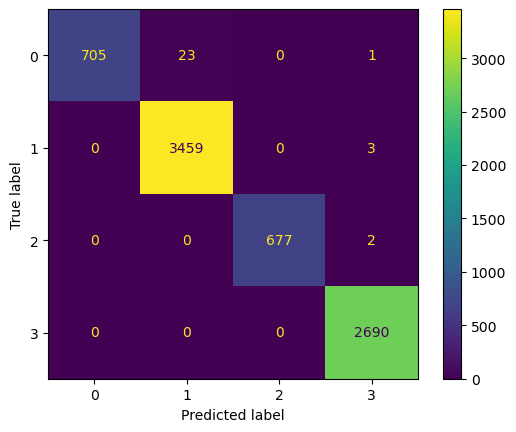

In [36]:
# Get actual and predicted values
dataset =  NucleusTypeDataset(csv_file='/kaggle/input/deep-learning-for-msc-2022-23/train.csv',
                         root_dir= '/kaggle/input/deep-learning-for-msc-2022-23/train',
                         transform=transform)

loader = DataLoader(dataset, batch_size=best_trial.config["batch_size"], shuffle=True)

# criterion = nn.CrossEntropyLoss()
y_actual=[]
y_pred=[]
with torch.no_grad():
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = pre_trained_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        size = labels.size(0)
        for i in range(0,size):
            y_actual.append(int(labels[i]))
            y_pred.append(int(predicted[i]))

# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y_actual, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2, 3])

cm_display.plot()
plt.show()

In [37]:
# Captum Model Part
ig = IntegratedGradients(pre_trained_model)
image_path = '/kaggle/input/deep-learning-for-msc-2022-23/test/14840.png'
img = Image.open(image_path)

In [38]:
transform = transforms.Compose([
 transforms.Resize(100),
 transforms.CenterCrop(100),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
)

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

In [39]:
output = pre_trained_model(input.to(device))
output = F.softmax(output, dim=1)
pred_label_idx = torch.topk(output, 1)
# pred_label_idx.squeeze_()
_, pred_label_idx = torch.topk(output, 1)


## Gradient-based attribution

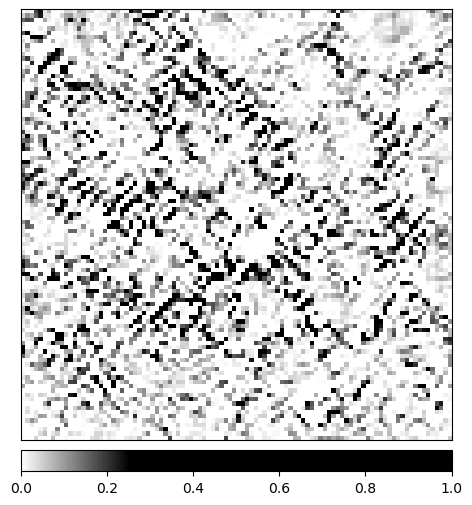

In [40]:
integrated_gradients = IntegratedGradients(pre_trained_model)
attributions_ig = integrated_gradients.attribute(input.to(device), target=pred_label_idx, n_steps=200)

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

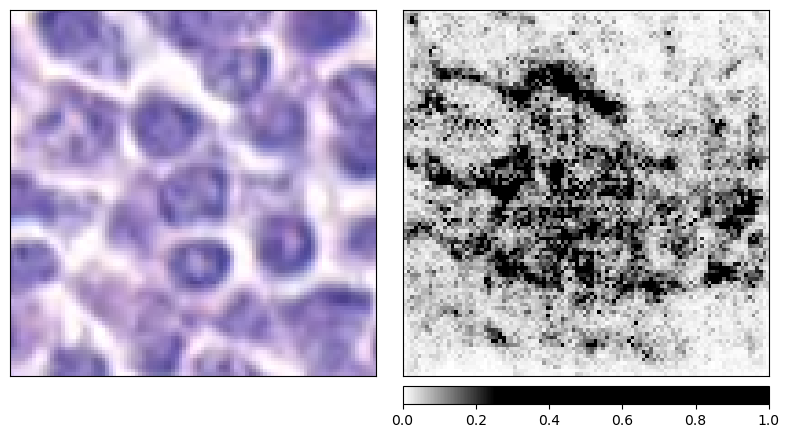

In [41]:
torch.cuda.empty_cache()
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input.to(device), nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


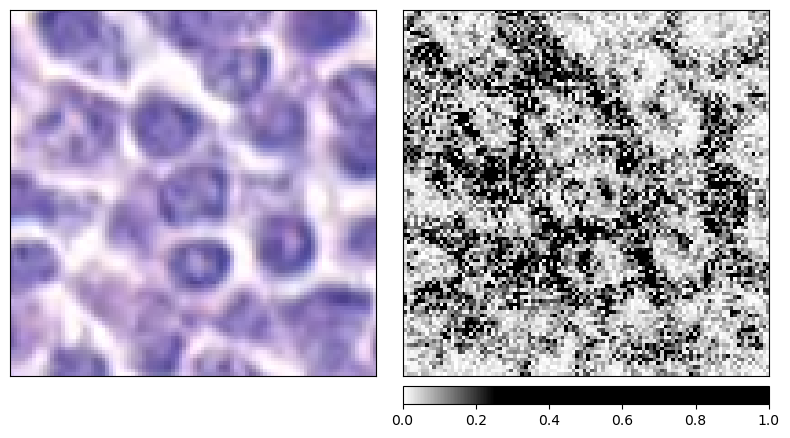

In [42]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(pre_trained_model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input.to(device) * 0, input .to(device)* 1])

attributions_gs = gradient_shap.attribute(input.to(device),
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


## Occlusion-based attribution

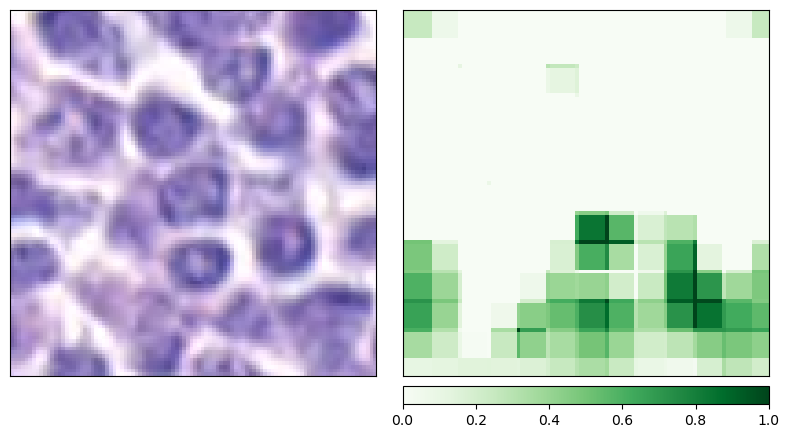

In [43]:
occlusion = Occlusion(pre_trained_model)

attributions_occ = occlusion.attribute(input.to(device),
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )


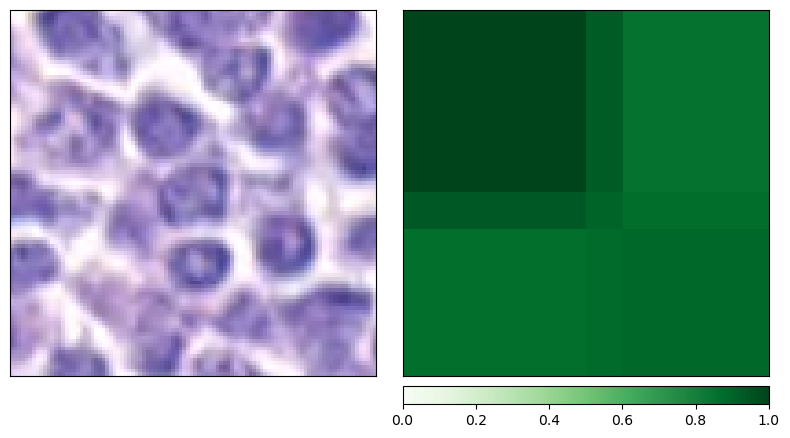

In [44]:
occlusion = Occlusion(pre_trained_model)

attributions_occ = occlusion.attribute(input.to(device),
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )